In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
from qiskit import QuantumCircuit,  ClassicalRegister, transpile
import matplotlib.pyplot as plt
from qiskit.providers.basic_provider import BasicProvider
from openqaoa.problems import FromDocplex2IsingModel
from docplex.mp.model import Model
from matplotlib import cm
from qiskit_ibm_transpiler.transpiler_service import TranspilerService
from copy import copy


backend = BasicProvider().get_backend("basic_simulator")
%matplotlib inline


In [2]:
def random_samples(num_samples, n_qubits):
    """
    Generates a dictionary with random bitstrings as keys and their occurrences as values.
    
    Parameters:
    num_samples (int): Number of samples to generate.
    n_qubits (int): Length of each bitstring.
    
    Returns:
    dict: Dictionary with bitstrings as keys and their counts as values.
    """
    random_samples = defaultdict(int)
    for _ in range(num_samples):
        # Generate a random bitstring of length n_qubits with 0s and 1s
        bitstring = "".join(str(i) for i in np.random.choice([0,1], n_qubits))
        random_samples[bitstring] += 1
    return random_samples

def repeat_subgraph(G, qubits_line):
    """
    Repeats a subgraph structure along a given qubit line.
    
    Parameters:
    G (networkx.Graph): The base graph to be repeated.
    qubits_line (list): List of qubit indices defining the repetition pattern.
    
    Returns:
    networkx.Graph: The expanded graph with repeated subgraph structure.
    """
    n_qubits = G.number_of_nodes()  # Number of nodes in the original graph
    n_reps = len(qubits_line) // n_qubits  # Number of times to repeat the graph
    GT = nx.Graph()
    
    # Add nodes from the repeated structure
    GT.add_nodes_from(qubits_line[:n_reps * n_qubits])
    
    # Repeat the edges with corresponding weights
    for rep in range(n_reps):
        for i, j in G.edges:
            w = G[i][j]["weight"]  # Edge weight
            GT.add_weighted_edges_from([[qubits_line[i + rep * n_qubits], qubits_line[j + rep * n_qubits], w]])
    
    return GT

def cost_mis(x, G):
    """
    Computes the cost function for the Maximum Independent Set (MIS) problem.
    
    Parameters:
    x (str): Bitstring representing a solution.
    G (networkx.Graph): The input graph.
    
    Returns:
    int: The computed cost value.
    """
    penalty = 0 
    
    # Penalize solutions where adjacent nodes are both 1 (violating independence)
    for i, j in G.edges:
        if x[i] + x[j] == "11":
            penalty += 2
    
    # Compute cost: negative of number of selected nodes plus penalty
    return -x.count("1") + penalty

def objective_MIS(samples_dict, G, optimal):
    """
    Computes the objective function for the Maximum Independent Set (MIS) problem.
    
    Parameters:
    samples_dict (dict): Dictionary of sampled bitstrings with their counts.
    G (networkx.Graph): The input graph.
    optimal (str): The optimal solution bitstring.
    
    Returns:
    dict: Dictionary containing results, best cost, ratio metric, and probability of optimal solution.
    """
    best_cost = cost_mis(optimal, G)  # Compute the best known cost
    results = []  # Store cost-related metrics
    probability = 0  # Probability of observing optimal solution
    
    for bitstring, counts in samples_dict.items():
        cost = cost_mis(bitstring, G)  # Compute cost for the sampled bitstring
        r = cost / best_cost  # Ratio to optimal cost
        results.append([cost, r, counts])
        
        # Count occurrences of optimal solution
        if abs(cost - best_cost) < 1e-4:
            probability += counts
        
        # If a better cost is found, print a message
        if cost < best_cost:
            print(f"There is a better cost than that of CPLEX: {cost - best_cost}")
    
    results = np.array(results)  # Convert to numpy array for easier computation
    shots = np.sum(results[:, 2])  # Total number of samples
    rT = np.sum(results[:, 0] * results[:, 2]) / (shots * best_cost)  # Weighted ratio metric
    probability /= shots  # Normalize probability
    
    return {"results": results, "G": G, "best_cost": best_cost, "r": rT, "probability": probability}


In [3]:
# This code is based on the research presented in the paper "SWAP-less
# Implementation of Quantum Algorithms": https://arxiv.org/abs/2408.10907

def sequence_2q(nq):
    """
    Generates a sequence of two-qubit interactions based on the number of qubits.
    
    Parameters:
    nq (int): Number of qubits.
    
    Returns:
    list: A list representing the sequence of two-qubit operations.
    """
    list_2q = [nq * [0]]
    list_2q[0][0] = (0,)
    for j in range(1, nq):
        if len(list_2q[0][j-1]) == 1:
            if j % 2:
                list_2q[0][j] = (j,)
            else:
                list_2q[0][j] = (list_2q[0][j-1][0], nq-1)
        else:
            list_2q[0][j] = (list_2q[0][j-1][0] + j % 2, list_2q[0][j-1][1] - 1 + j % 2)
    
    for i in range(1, nq):
        array_i = copy(list_2q[i-1])
        if i % 2 == 1:
            lista = list(list_2q[i-1][0]) + list(list_2q[i-1][1])
            unique_list = tuple(sorted([item for item in lista if lista.count(item) == 1]))
            array_i[0] = unique_list
        for j in range(i % 2, nq-2, 2):
            lista = list(list_2q[i-1][j]) + list(list_2q[i-1][j+1]) + list(list_2q[i-1][j+2])
            unique_list = tuple(sorted([item for item in lista if lista.count(item) == 1]))
            array_i[j+1] = unique_list
        if nq % 2 == i % 2:
            lista = list(list_2q[i-1][nq-1]) + list(list_2q[i-1][nq-2])
            unique_list = tuple(sorted([item for item in lista if lista.count(item) == 1]))
            array_i[nq-1] = unique_list
        list_2q.append(array_i)
    return list_2q

def UA(qc, G, gamma, sequence_2q, pi):
    """
    Applies the problem Hamiltonian evolution to the quantum circuit.
    
    Parameters:
    qc (QuantumCircuit): Quantum circuit object.
    G (networkx.Graph): Graph representing the problem instance.
    gamma (float): Parameter for evolution.
    sequence_2q (list): Sequence of two-qubit interactions.
    pi (int): Iteration step.
    """
    nq = G.number_of_nodes()
    max_weight = np.max(np.abs([G[i][j]["weight"] for i, j in G.edges()]))
    for k in range(nq):
        for qi, ij in enumerate(sequence_2q[k]):
            if k > 0 and ij == sequence_2q[k-1][qi]:
                pass
            elif len(ij) == 2:
                if ij[0] in list(G[ij[1]].keys()):
                    qc.rz(2 * G[ij[0]][ij[1]]["weight"] * gamma / max_weight, qi)
            elif len(ij) == 1:
                if ij[0] in list(G[ij[0]].keys()):
                    qc.rz(2 * G[ij[0]][ij[0]]["weight"] * gamma / max_weight, qi)
        if k < nq - 1:
            for i in range((k + (nq % 2) * pi) % 2, nq-1, 2):
                qc.cx(i+1, i)
            for j in range(((k + 1) + (nq % 2) * pi) % 2, nq-1, 2):
                qc.cx(j, j+1)

def UB(qc, pi, nq, beta):
    """
    Applies the mixing Hamiltonian evolution to the quantum circuit.
    
    Parameters:
    qc (QuantumCircuit): Quantum circuit object.
    pi (int): Iteration step.
    nq (int): Number of qubits.
    beta (float): Parameter for evolution.
    """
    qc.rx(-2*beta, 0)
    if pi % 2:
        qc.rx(-2*beta, nq-1)
    for j in range(2):
        for i in range(j + pi % 2, nq-1, 2):
            qc.cx(i, i+1)
            qc.rx(-2 * beta, i)
            qc.cx(i, i+1)

def qaoa_parity_optimal(gammas, betas, G):
    """
    Implements the QAOA with parity optimization.
    
    Parameters:
    gammas (list): List of gamma parameters.
    betas (list): List of beta parameters.
    G (networkx.Graph): Graph representing the problem instance.
    
    Returns:
    QuantumCircuit: The optimized QAOA circuit.
    """
    nq = G.number_of_nodes()
    list_parity = sequence_2q(nq)
    p = len(gammas)
    qc = QuantumCircuit(nq)
    qc.h(range(nq))
    for pi in range(p):
        UA(qc, G, gammas[pi], list_parity, pi)
        UB(qc, pi, nq, betas[pi])
        list_parity = list(reversed(list_parity))
    return qc 

def decode_parity(sample, p):
    """
    Decodes the measured parity sample back to original bit configuration.
    
    Parameters:
    sample (str): Bitstring sample.
    p (int): Iteration step.
    
    Returns:
    str: Decoded bitstring.
    """
    spin = {1:"0", -1:"1"}
    sz = [(1 if i == "0" else -1) for i in sample]
    nq = len(sample)
    x = nq * [0]
    if p % 2 == 0:
        list_parity = sequence_2q(nq)[0]
        list_q = range(nq)
    else:
        list_parity = sequence_2q(nq)[-1]
        list_q = reversed(range(nq))
    for i in list_q:
        if len(list_parity[i]) == 1:
            x[list_parity[i][0]] = sz[i]
        else:
            if x[list_parity[i][0]] != 0:
                x[list_parity[i][1]] = sz[i]/x[list_parity[i][0]]
            elif x[list_parity[i][1]] != 0:
                x[list_parity[i][0]] = sz[i]/x[list_parity[i][1]]
            else:
                print(list_parity[i])
    return "".join(spin[xi] for xi in x)


In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
service = QiskitRuntimeService()


In [5]:
backends = {}
backends["ibm_fez"] = service.backend("ibm_fez", use_fractional_gates=True)
backends["ibm_torino"] = service.backend("ibm_torino", use_fractional_gates=True)
backends["ibm_brisbane"] = service.backend("ibm_brisbane")
backends["qasm_simulator"] = BasicProvider().get_backend("basic_simulator")


In [ ]:
def qaoa_mis(gammas, betas, hamiltonian, num_qubits):
    """
    Implements the QAOA for the Maximum Independent Set (MIS) problem.
    
    Parameters:
    gammas (list): List of gamma parameters.
    betas (list): List of beta parameters.
    hamiltonian (dict): Hamiltonian representing the problem instance keys:interactions | values: weights.
    
    Returns:
    QuantumCircuit: The QAOA circuit for solving MIS.
    """
    p = len(gammas)
    nodes = range(num_qubits)
    max_weight = max(np.abs([v for k, v in hamiltonian.items() if len(k) == 2]))
    qc = QuantumCircuit(num_qubits, len(nodes))
    qc.h(nodes)
    for pi in range(p):
        for term, weight in hamiltonian.items():
            if abs(weight) < 1e-9:
                pass
            else:
                if len(term) == 1:
                    qc.rz(2 * gammas[pi] * weight / max_weight, term[0])
                elif len(term) == 2:
                    qc.rzz(2 * gammas[pi] * weight / max_weight, term[0], term[1])
                else:
                    raise TypeError("Not a valid input")
        qc.rx(-2 * betas[pi], nodes)
    qc.measure(nodes, reversed(range(len(nodes))))
    return qc

def cost(x, G):
    """
    Computes the cost function for the Maximum Independent Set problem.
    
    Parameters:
    x (str): Bitstring solution.
    G (networkx.Graph): Graph representing the problem instance.
    
    Returns:
    int: Cost value (negative if constraint is violated, otherwise count of independent nodes).
    """
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            return -1
    return x.count("1")

def energy(x, G, lambd=2):
    """
    Computes the energy function for the MIS problem with a penalty term.
    
    Parameters:
    x (str): Bitstring solution.
    G (networkx.Graph): Graph representing the problem instance.
    lambd (float): Penalty factor for constraint violations.
    
    Returns:
    int: Energy value for the given bitstring.
    """
    suma = 0
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            suma += lambd
    return suma - x.count("1")

def cplex(G, lmbd=2):
    """
    Formulates the MIS problem as a Mixed-Integer Programming (MIP) model using CPLEX.
    
    Parameters:
    G (networkx.Graph): Graph representing the problem instance.
    lmbd (float): Penalty factor for constraint violations.
    
    Returns:
    Model: CPLEX optimization model for solving MIS.
    """
    mdl = Model()
    x = {i: mdl.binary_var(name=f"x{i}") for i in sorted(G.nodes)}
    mdl.minimize(-mdl.sum(x.values()) + lmbd * sum(x[i] * x[j] for i, j in G.edges()))
    return mdl

def greedy_improvement(samples_dict, G, random=False):
    """
    Applies a classical greedy algorithm to improve the sampled solutions.
    
    Parameters:
    samples_dict (dict): Dictionary of measured bitstrings and their counts.
    G (networkx.Graph): Graph representing the problem instance.
    random (bool): Whether to randomly shuffle qubit order during mitigation.
    
    Returns:
    dict: Dictionary of mitigated bitstrings and their updated counts.
    """
    change = {"0": "1", "1": "0"}
    nq = G.number_of_nodes()
    new_samples = defaultdict(int)
    for bitstring, counts in samples_dict.items():
        for _ in range(counts):
            best_string = bitstring
            best_cost = energy(bitstring, G)
            list_qubits = np.arange(nq)
            if random:
                np.random.shuffle(list_qubits)
            for qi in list_qubits:
                new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
                new_cost = energy(new_string, G)
                if new_cost < best_cost:
                    best_string = new_string
                    best_cost = new_cost
            new_samples[best_string] += 1
    return new_samples

def hamming_distance(x1, x2):
    """
    Computes the Hamming distance between two bitstrings.
    
    Parameters:
    x1 (str): First bitstring.
    x2 (str): Second bitstring.
    
    Returns:
    int: Hamming distance between the two bitstrings.
    """
    distance = 0
    for i, s in enumerate(x1):
        if s != x2[i]:
            distance += 1
    return distance


# Problem graph

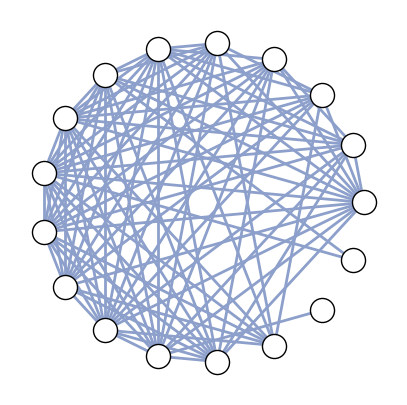

In [5]:
problem_name =  ["17_farm", "17_mammalia-kangaroo-interactions","32_ibm32"][1]
graph = np.load(f"./Data/Graphs/{problem_name}.npy", allow_pickle=True).item()
G = graph["G"]
nq = graph["nq"]
colors = plt.get_cmap("Set2")
fig, ax = plt.subplots(figsize=(5,5))
edge_colors= colors(2)
pos = nx.circular_layout(G)
ax1 = nx.draw(G, pos=pos, ax=ax, font_size=9, edgecolors="black", width=2, edge_color=edge_colors, node_color="white", )
fig.savefig(f"./Figures/MIS_{problem_name}.pdf", bbox_inches="tight", transparent=True)

# Problem solutions by brute force

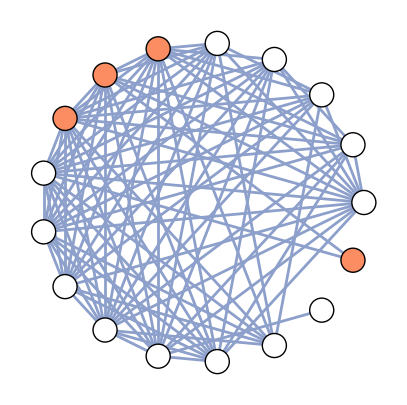

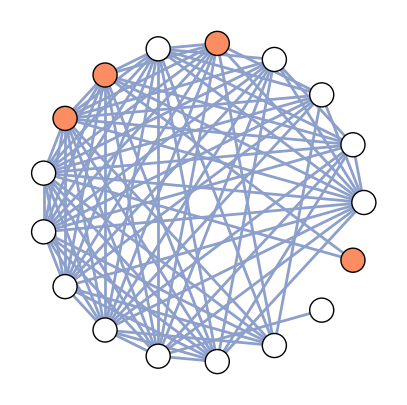

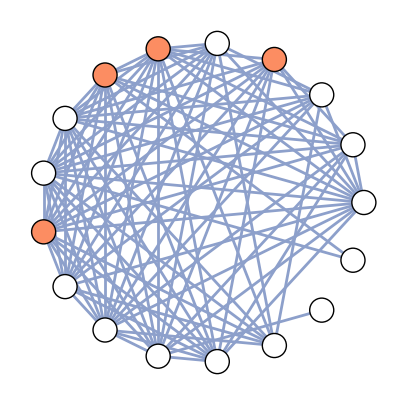

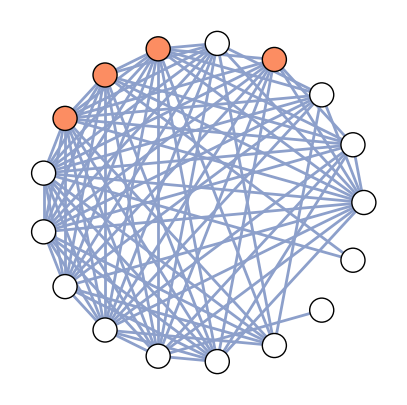

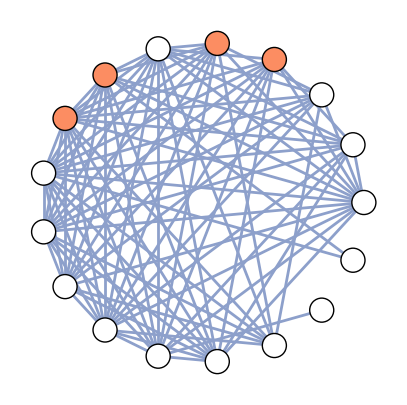

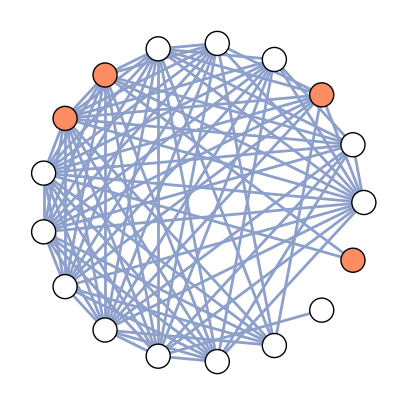

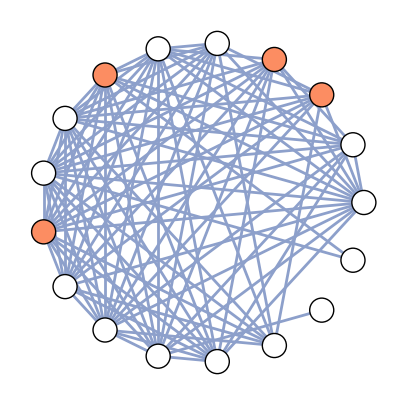

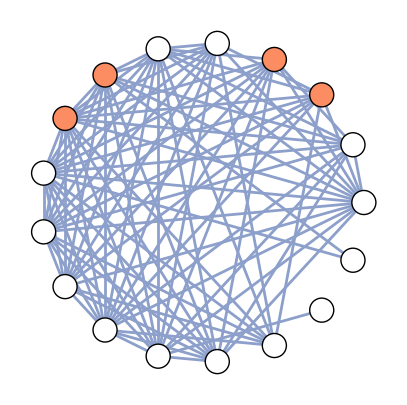

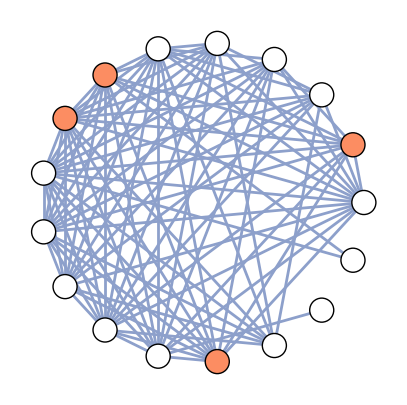

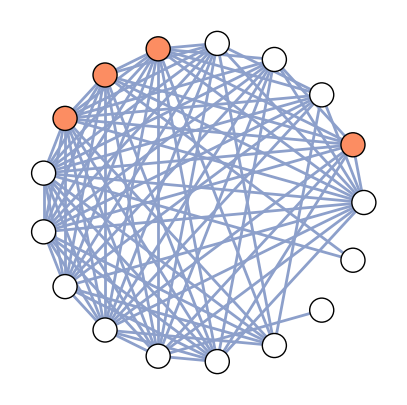

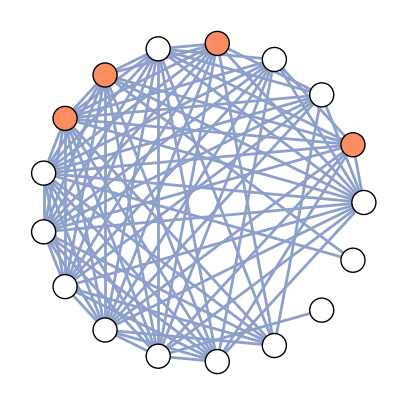

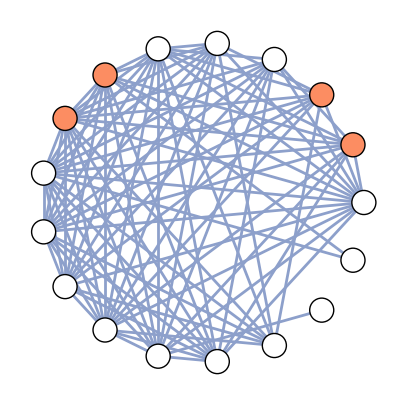

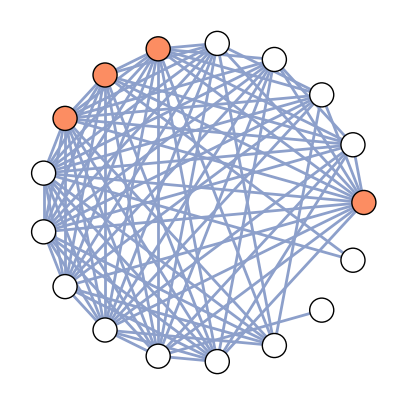

In [8]:
# Brute force
sols = defaultdict(list)
pos = nx.circular_layout(G)

results = {}
results["G"] = G
results["nq"] = G.number_of_nodes()
if nq < 20:
    for i in range(2**nq):
        x = np.binary_repr(i, nq)
        sols[cost(x, G)].append(x)
    opt_sols = sols[max(sols.keys())]
    results["opt_sols"] = opt_sols
    for i, sol in enumerate(opt_sols):
        fig, ax = plt.subplots(figsize=(5,5))
        edge_colors= colors(2)
        theta=51.4
        node_color=[colors(1) if i == "1" else "white" for i in sol]
        ax1 = nx.draw(G,  pos=pos, ax=ax, font_size=3, edgecolors="black", width=2, edge_color=edge_colors, node_color=node_color, )
        fig.savefig(f"./Figures/MIS_{problem_name}_sol{i}.pdf", bbox_inches="tight", transparent=True)

# Solving the problem using CPLEX

In [9]:
lambd = 1.1
mdl = cplex(G, lambd)
mdl.solve()
cplex_sol = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
results["cplex_sol"] = cplex_sol
ising_model = FromDocplex2IsingModel(mdl).ising_model
results["hamiltonian"] = {tuple(t):w for t, w in zip(ising_model.terms, ising_model.weights)}
results["nq"] = nq



# Searching best $\Delta_\beta$ and $\Delta_\gamma$ in LR-QAOA with 10 shots

In [10]:
# Parameter initialization
lambd = 1.1  # Penalty factor for constraint violations
shots = 10  # Number of quantum circuit executions
nq = G.number_of_nodes()
p = 2  # Number of QAOA layers

# Convert CPLEX model to Ising representation
ising_model = results["hamiltonian"]

delta_gammas = np.linspace(0.1, 0.5, 5)
delta_betas = np.linspace(0.1, 0.5, 5)
probability = np.zeros((len(delta_betas), len(delta_gammas)))
energy_matrix = np.zeros((len(delta_betas), len(delta_gammas)))

max_prob = 0

# Iterate over beta and gamma values to find optimal parameters
for i, delta_beta in enumerate(delta_betas):
    print(f" {i+1} out of {len(delta_betas)}")
    for j, delta_gamma in enumerate(delta_gammas):
        gammas = np.arange(1, p+1) * delta_gamma/p
        betas = np.arange(1, p+1)[::-1] * delta_beta/p
        qc = qaoa_mis(gammas, betas, ising_model, nq)
        samples = backend.run(qc, shots=shots).result().get_counts()
        total_opt = sum([samples[i] for i in opt_sols if i in samples.keys()])
        probability[i, j] = total_opt / shots
        if probability[i, j] > max_prob:
            max_prob = probability[i, j]
            beta_opt = delta_beta
            gamma_opt = delta_gamma
        energy_matrix[i, j] = np.sum([c * energy(sample, G) for sample, c in samples.items()]) / shots

# Store results
results["landscape"] = {"p": p, "probability": probability, "delta_gammas": delta_gammas, "delta_betas": delta_betas, "shots": shots, "energy": energy_matrix}

nxx, nyy = np.argmin(energy_matrix)%len(delta_betas), np.argmin(energy_matrix)//len(delta_betas)
results["landscape"]["beta"] = delta_betas[nyy]
results["landscape"]["gamma"] = delta_gammas[nxx]
print("beta", delta_betas[nyy], "gamma", delta_gammas[nxx])


 1 out of 5
 2 out of 5
 3 out of 5
 4 out of 5
 5 out of 5
beta 0.5 gamma 0.1


Optimal values of gamma:0.1 and beta:0.5


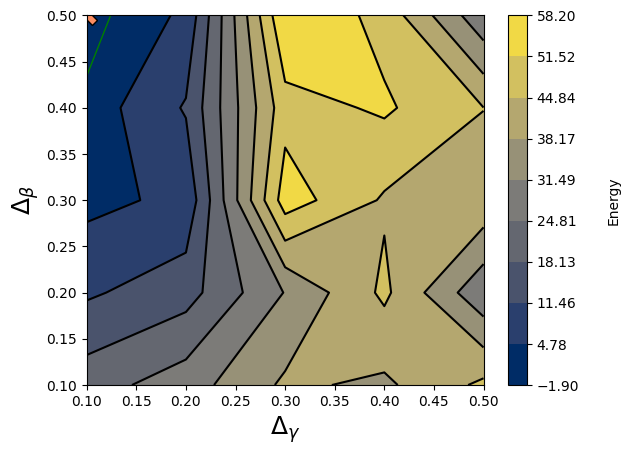

In [20]:
# Load stored results from the QAOA landscape exploration
delta_gammas = results["landscape"]["delta_gammas"]
delta_betas = results["landscape"]["delta_betas"]
Z = results["landscape"]["energy"]

# Create a mesh grid for plotting
X, Y = np.meshgrid(delta_gammas, delta_betas)
prop = "Energy"

# Initialize the figure and axis for contour plot
fig, ax = plt.subplots()
nxx, nyy = np.argmin(Z) % len(delta_betas), np.argmin(Z) // len(delta_betas)

# Define contour levels and color normalization
levels = np.round(np.linspace(np.min(Z), np.max(Z), 10), 2)
norm = cm.colors.Normalize(vmax=np.max(Z), vmin=np.min(Z))
cmap = cm.coolwarm

# Create filled contour plot
cset1 = ax.contourf(X, Y, Z, levels, norm=norm, cmap="cividis")
# Create contour lines
cset2 = ax.contour(X, Y, Z, cset1.levels, colors='k')
cset2.set_linestyle('solid')
# Highlight zero-energy contour
cset3 = ax.contour(X, Y, Z, (0,), colors='g', linewidths=1)

# Add colorbar with label
colorbar = fig.colorbar(cset1, ax=ax)
colorbar.set_label(prop, rotation=90, labelpad=20)

# Label axes
ax.set_xlabel(r"$\Delta_{\gamma}$", fontsize=18)
ax.set_ylabel(r"$\Delta_{\beta}$", fontsize=18)

# Mark the optimal point with an 'X' symbol
ax.plot(delta_gammas[nxx], delta_betas[nyy], marker="X", markersize=14, markeredgecolor="black", color=colors(1))

# Print the optimal parameter values
print(f"Optimal values of gamma:{delta_gammas[nxx]} and beta:{delta_betas[nyy]}")


In [21]:
# Define problem parameters
lambd = 1.1  # Regularization parameter
shots = 1000  # Number of quantum circuit executions

# Extract optimal values of gamma and beta from previous results
delta_gamma = delta_gammas[nxx]
delta_beta = delta_betas[nyy]
# Convert CPLEX solution into an Ising model representation
ising_model = results["hamiltonian"]

# Define the maximum number of QAOA layers
max_p = 10
TTS = []  # Time-to-solution list
STS = []  # Success-to-solution list
probs = []  # Probability of obtaining the optimal solution
list_p = range(1, max_p + 1)  # Range of QAOA layers

# Loop over different QAOA depths
for p in list_p:
    # Generate QAOA parameters using linear spacing
    gammas = np.arange(1, p + 1) * delta_gamma / p
    betas = np.arange(1, p + 1)[::-1] * delta_beta / p
    
    # Create and run the QAOA quantum circuit
    qc = qaoa_mis(gammas, betas, ising_model, nq)
    samples = backend.run(qc, shots=shots).result().get_counts()
    
    # Compute probability of obtaining the optimal solution
    prob = sum([samples[i] for i in results["opt_sols"] if i in samples.keys()]) / shots
    probs.append(prob)
    
    # Compute Time-To-Solution (TTS) and Success-To-Solution (STS)
    TTS.append(p * np.ceil(np.log(1 - 0.99) / np.log(1 - prob)))
    STS.append(max(1, np.ceil(np.log(1 - 0.99) / np.log(1 - prob))))
    
    # Print the current QAOA depth and TTS
    print(f"p={p} || TTS = {round(TTS[-1])}")

# Print the minimum TTS found
print(f"min TTS: {min(TTS)}")

# Store results in the results dictionary
results["landscape"]["optimal"] = {}
results["landscape"]["optimal"]["TTS"] = np.array(TTS)
results["landscape"]["optimal"]["STS"] = np.array(STS)
results["landscape"]["optimal"]["probability"] = np.array(probs)
results["landscape"]["optimal"]["beta"] = delta_beta
results["landscape"]["optimal"]["gamma"] = delta_gamma
results["landscape"]["optimal"]["list_p"] = list_p

# Save results to a file
np.save(f"./Data/{problem_name}_results.npy", results)

p=1 || TTS = 254
p=2 || TTS = 176
p=3 || TTS = 228
p=4 || TTS = 392
p=5 || TTS = 415
p=6 || TTS = 474
p=7 || TTS = 560
p=8 || TTS = 480
p=9 || TTS = 324
p=10 || TTS = 260
min TTS: 176.0


min TTS 176.0 | p = 2


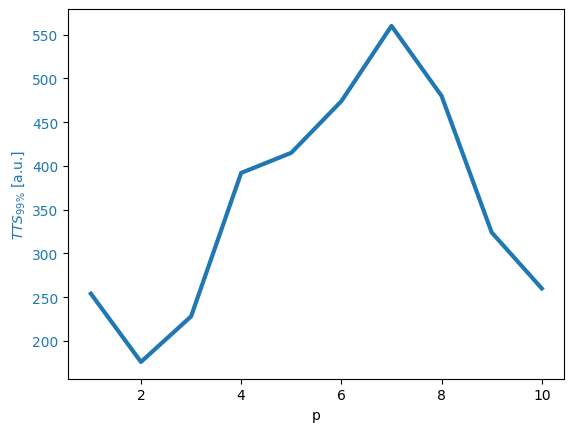

In [22]:
# This code visualizes and analyzes the Time-To-Solution (TTS) for different QAOA depths

# Extract the list of QAOA layers and corresponding TTS and STS values from stored results
list_p = results["landscape"]["optimal"]["list_p"]
TTS = results["landscape"]["optimal"]["TTS"]
STS = results["landscape"]["optimal"]["STS"]

# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Plot the TTS values as a function of QAOA depth
ax.plot(list_p, TTS, linewidth=3)

# Label the x-axis as the number of QAOA layers
ax.set_xlabel("p")

# Label the y-axis as Time-To-Solution with appropriate color coding
ax.set_ylabel(r"$TTS_{99\%}$ [a.u.]", color="tab:blue")
ax.tick_params(axis='y', labelcolor='tab:blue')

# Print the minimum TTS value and the corresponding QAOA depth
print(f"min TTS {min(TTS)} | p = {list_p[np.argmin(TTS)]}")


min TTS 176.0 | p = 2


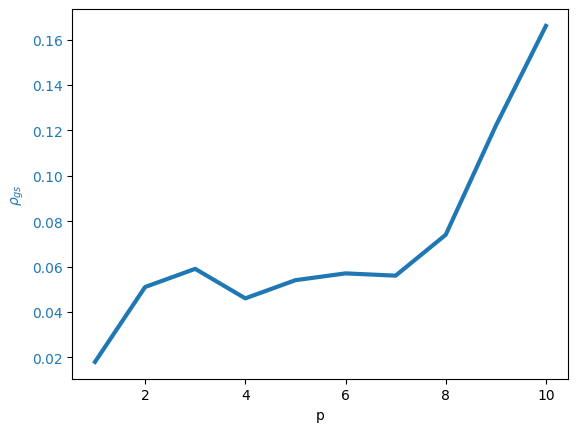

In [23]:
# This code visualizes and analyzes the probability of obtaining the ground state for different QAOA depths

# Extract the list of QAOA layers and corresponding probability values from stored results
list_p = results["landscape"]["optimal"]["list_p"]
probability = results["landscape"]["optimal"]["probability"]

# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Plot the probability values as a function of QAOA depth
ax.plot(list_p, probability, linewidth=3)

# Label the x-axis as the number of QAOA layers
ax.set_xlabel("p")

# Label the y-axis as the ground state probability with appropriate color coding
ax.set_ylabel(r"$\rho_{gs}$", color="tab:blue")
ax.tick_params(axis='y', labelcolor='tab:blue')

# Print the minimum TTS value and the corresponding QAOA depth
print(f"min TTS {min(TTS)} | p = {list_p[np.argmin(TTS)]}")


In [24]:
problem_name =  "17_mammalia-kangaroo-interactions"
shots = 1000
results = np.load(f"./Data/{problem_name}_results.npy", allow_pickle=True).item()
p = results["landscape"]["optimal"]["list_p"][np.argmin(results["landscape"]["optimal"]["TTS"])]
gammas = np.arange(1, p+1) * results["landscape"]["optimal"]["gamma"]/p
betas = np.arange(1, p+1)[::-1] * results["landscape"]["optimal"]["beta"]/p
lambd = 1.1
ising_model = results["hamiltonian"]
qc = qaoa_mis(gammas, betas, ising_model, results["nq"])
samples = backend.run(qc, shots=shots).result().get_counts()
samples_random = random_samples(shots, results["G"].number_of_nodes())
optimal_res = objective_MIS(samples, results["G"], results["opt_sols"][0])
random_res = objective_MIS(samples_random, results["G"], results["opt_sols"][0])
results["best_tts"] = optimal_res
results["random"] = random_res

Text(0.5, 0, 'Objective value')

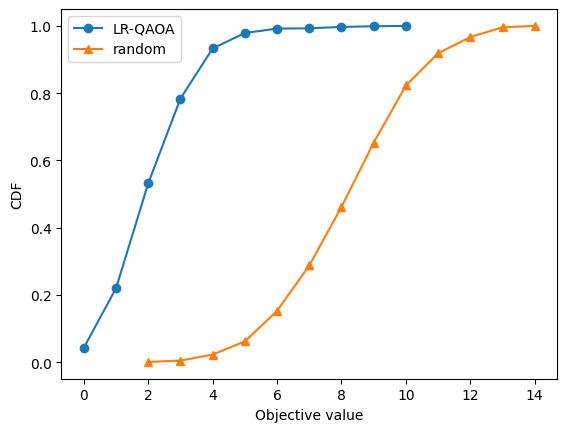

In [25]:
fig, ax = plt.subplots()
objective = defaultdict(int)

for s, c in samples.items():
    objective[s.count("1")] += c 
cmf = [objective[i]/shots for i in sorted(objective.keys())]
cmf = np.cumsum(cmf)
ax.plot(sorted(objective.keys()), cmf, marker="o", label="LR-QAOA")

objective_random = defaultdict(int)
for s, c in samples_random.items():
    objective_random[s.count("1")] += c 
cmf_r = [objective_random[i]/shots for i in sorted(objective_random.keys())]
cmf_r = np.cumsum(cmf_r)
ax.plot(sorted(objective_random.keys()), cmf_r, marker="^", label="random")
ax.legend()
ax.set_ylabel("CDF")
ax.set_xlabel("Objective value")



In [26]:
np.save(f"./Data/{problem_name}_results.npy", results)

# Executing on real device with parity Encoding

In [30]:
problem_name =  "17_mammalia-kangaroo-interactions"

# Load the results from a .npy file corresponding to the selected problem
# The results are loaded as a Python dictionary using .item() after loading the numpy array
results = np.load(f"./Data/{problem_name}_results.npy", allow_pickle=True).item()

# Extract the number of qubits (nq) from the results
nq = results["nq"]

# Initialize an empty graph (undirected) to represent the Hamiltonian
G_ham = nx.Graph()

# Loop through the Hamiltonian dictionary, which has pairs of indices and their corresponding values
for ij, v in results["hamiltonian"].items():
    # If the index is of length 1 (e.g., single node), add a self-loop with weight v
    if len(ij) == 1:
        G_ham.add_weighted_edges_from([[ij[0], ij[0], v]])
    # If the index is of length 2 (pair of nodes), add an edge between the nodes with weight v
    elif len(ij) == 2:
        G_ham.add_weighted_edges_from([[ij[0], ij[1], v]])
    else:
        # Raise an error if the index length is neither 1 nor 2
        raise ValueError()

# Define a list p layers for LR-QAOA
ps = [2, 2, 2, 2, 2]

# Define the backend name (specifically referring to the IBM Quantum computer "ibm_torino")
backend_name = "ibm_torino"

# Extract optimal gamma and beta values from the results (used for QAOA)
delta_gamma = results["landscape"]["optimal"]["gamma"]
delta_beta = results["landscape"]["optimal"]["beta"]

# Set the method to "parity", indicating the parity scheme for encoding the QAOA problem
method = "parity"

# Create a list to store quantum circuits
circs = []

# Loop over each value in the list ps (probably representing the different p-values for QAOA)
for p in ps:
    # Generate gamma and beta values for each p (dividing the optimal values accordingly)
    gammas = np.arange(1, p + 1) * delta_gamma / p
    betas = np.arange(1, p + 1)[::-1] * delta_beta / p
    
    # If the method is "parity", generate a quantum circuit for the QAOA with parity optimization
    if method == "parity":
        qc = qaoa_parity_optimal(gammas, betas, G_ham)
        # Add a classical register to the quantum circuit with nq classical bits
        qc.add_register(ClassicalRegister(nq))
        # Create a range of qubit indices for measurement
        qord = range(nq)
        # Add measurement operations on all qubits to the classical register
        qc.measure(qord, range(nq))

    # If not using a simulator, transpile the quantum circuit to the selected backend
    if backend_name != "qasm_simulator":
        qc = transpile(qc, backend=backends[backend_name], optimization_level=3)
    else:
        # If using the "qasm_simulator", transpile with specific coupling map and gate set
        qc = transpile(qc, coupling_map=[[i, i + 1] for i in range(nq - 1)], optimization_level=3, basis_gates=['rx', 'cz', 'id', 'rz', 'sx', 'x'])
        
        # Run the simulation on the backend and collect the results (shot-based)
        samples = {decode_parity(k[::-1], p): c for k, c in backends[backend_name].run(qc, shots=shots).result().get_counts().items()}
        
        # Calculate the total number of optimal solutions based on the samples
        total_opt = sum([samples[i] for i in opt_sols if i in samples.keys()])
        
        # Calculate the probability of the ideal solution by dividing by total shots
        probability_ideal = total_opt / shots

    # Print the current p, number of gates, and circuit depth for debugging or monitoring
    print(f"p:{p} gates: {dict(qc.count_ops())}, depth:{qc.depth()}")
    
    # Add the generated quantum circuit to the list of circuits
    circs.append(qc)


p:2 gates: {'rz': 614, 'cz': 545, 'sx': 335, 'rx': 307, 'measure': 17}, depth:157
p:2 gates: {'rz': 614, 'cz': 545, 'sx': 335, 'rx': 307, 'measure': 17}, depth:157
p:2 gates: {'rz': 614, 'cz': 545, 'sx': 335, 'rx': 307, 'measure': 17}, depth:157
p:2 gates: {'rz': 614, 'cz': 545, 'sx': 335, 'rx': 307, 'measure': 17}, depth:157
p:2 gates: {'rz': 614, 'cz': 545, 'sx': 335, 'rx': 307, 'measure': 17}, depth:157


In [177]:
shots = 1000
sampler = Sampler(mode=backends[backend_name])
submit_job = sampler.run(circs, shots=shots)
id = submit_job.job_id() # ID to retrieve the job once is done

data = {}
data["G"] = results["G"]
data["optimal"] = opt_sols
data["id"] = id
data["ps"] = ps
data["nq"] = results["nq"]
np.save(f"./Data/{backend_name}/{problem_name}_{method}.npy", data)

# Posprocessing

In [ ]:
# Define the backend, method, extra string, and problem name
backend_name = "ibm_torino"
method = "parity"
extra = ""
problem_name = "17_mammalia-kangaroo-interactions"

# Load the data from a .npy file using the specified backend, problem, and method.
# The data is loaded as a dictionary using .item()
data = np.load(f"./Data/{backend_name}/{problem_name}_{method}{extra}.npy", allow_pickle=True).item()

# Retrieve the job result from the service using the job ID (from previously stored results)
job = service.job(job_id=results["id"]).result()

# Collect the counts for each job in the total_samples list (output from the quantum device)
total_samples = [job[i].data.c.get_counts() for i in range(len(job))]

# Initialize empty dictionaries in data to store samples, post-processing results, and greedy improved results
data["samples"] = {}
data["posprocessing"] = {}
data["posprocessing_greedy"] = {}

# Loop through each value in the parameter list 'ps' from the data
for i, p in enumerate(data["ps"]):
    # Depending on the method, decode the samples and store them in the 'samples' dictionary
    if method == "parity":
        # Decode the samples using the 'decode_parity' function if the method is "parity"
        data["samples"][p] = {decode_parity(k[::-1], p):c for k, c in total_samples[i].items()}
    elif method == "swap":
        # If the method is "swap", just store the samples as-is without decoding
        data["samples"][p] = {k:c for k, c in total_samples[i].items()}

    # Perform post-processing on the samples and store the result
    data["posprocessing"][p] = objective_MIS(data["samples"][p], data["G"], data["optimal"][0])

    # Greedy improvement of the samples
    samples_mitig = greedy_improvement(data["samples"][p], data["G"], random=False)
    data["posprocessing_greedy"][p] = objective_MIS(samples_mitig, data["G"], data["optimal"][0])

    # Print the current value of p to track progress
    print(f" ----------- {p} --------------")

# Generate a set of random samples for comparison (10,000 samples in this case)
rand_samples = random_samples(10_000, data["nq"])

# Calculate the objective (e.g., MIS score) for the random samples and store the result
data["random"] = objective_MIS(rand_samples, data["G"], data["optimal"][0])

# Greedy improvement of the random samples
samples_mitig = greedy_improvement(rand_samples, data["G"], random=False)
data["random_greedy"] = objective_MIS(samples_mitig, data["G"], data["optimal"][0])

# Save the modified data (which includes the samples, post-processing results, and mitigated results) to a .npy file
np.save(f"./Data/{backend_name}/{problem_name}_{method}{extra}.npy", data)


FileNotFoundError: [Errno 2] No such file or directory: './Data/ibm_torino/17_mammalia-kangaroo-interactions_parity.npy'